<a href="https://colab.research.google.com/github/RodrigoMacedo99/Fundamentos-de-Programa-o-Paralela/blob/main/Hackathon_Filtro_Laplaciano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problema

O problema consiste em otimizar a aplicação do filtro laplaciano em matrizes quadradas

Este filtro é particularmente útil para detecção de bordas em imagens

Considerando uma imagem como uma matriz $M$ de números inteiros compreendidos de 0 a 255 (valores relativos à escala RGB), sua filtragem consiste em realizar uma operação de convolução entre $M$ e uma matriz de pesos $K$, denominada kernel

Em outras palavras, a matriz da imagem filtrada $F$ é definida como $F=M*K$

Para o caso do filtro laplaciano, pode-se utilizar a seguinte matriz como kernel:

$K=\begin{bmatrix}
  \phantom{-}0 & -1 & \phantom{-}0 \\
  -1 & \phantom{-}4 & -1 \\
  \phantom{-}0 & -1 & \phantom{-}0
 \end{bmatrix}$

## Validação dos códigos

Todos os códigos analisados foram validados através de sua implementação na filtragem da imagem `lenna.ppm` no tópico `Filtragem de lenna.ppm`.

*Caso deseje executar os códigos, faça upload da imagem `lenna.ppm` no ambiente de execução do colab. Ela pode ser baixada [aqui](https://drive.google.com/file/d/1FS-1spIbkbDBMh_KTRVuL4Ux23f275bm/view?usp=sharing)

### Imagem `lenna.ppm`

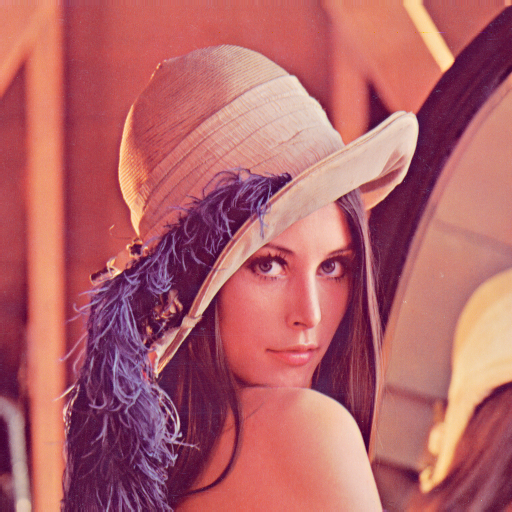

In [ ]:
from IPython.display import display
from PIL import Image
display(Image.open("lenna.ppm"))

In [ ]:
%%writefile compare_files.sh

#!/bin/bash

if [ ! -e "$1" ]; then
    echo "Erro: $1 não foi encontrado."
    exit 1
fi
if [ ! -e "$2" ]; then
    echo "Erro: $2 não foi encontrado."
    exit 1
fi

resultado_diff=$(diff "$1" "$2")

if [ -z "$resultado_diff" ]; then
    echo "O conteúdo dos arquivos é igual."
else
    echo "O conteúdo dos arquivos é diferente:"
    # echo "$resultado_diff"
fi

Overwriting compare_files.sh


In [ ]:
!chmod +x compare_files.sh

## Sequencial

### filtragem de `lenna.ppm`

In [ ]:
%%writefile laplacian_lenna_seq.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

struct pixel
{
    unsigned char r, g, b;
};

void read_ppm_image(struct pixel **img, int *out_width, int *out_height)
{
    FILE *fd;
    char type[3];
    int rgb_max, actual_width, actual_height, i, j;

    fd = fopen("lenna.ppm", "r");
    if (fd == NULL)
    {
        printf("failed opening file lenna.ppm\n");
        exit(-1);
    }

    fscanf(fd, "%s", type);
    if (strcmp(type, "P3") != 0)
    {
        printf("wrong format. P3 format expected\n");
        exit(-1);
    }

    fscanf(fd, "%d %d", &actual_width, &actual_height);

    if ((*img = (struct pixel *)malloc(actual_height * actual_width * sizeof(struct pixel))) == NULL)
    {
        printf("failed allocating memory for %d pixels\n", actual_height * actual_width);
        exit(-1);
    }

    fscanf(fd, "%d", &rgb_max);

    for (i = 0; i < actual_height; i++)
        for (j = 0; j < actual_width; j++)
        {
            fscanf(fd, "%hhu", &((*img)[i * actual_height + j].r));
            fscanf(fd, "%hhu", &((*img)[i * actual_height + j].g));
            fscanf(fd, "%hhu", &((*img)[i * actual_height + j].b));
        }

    *out_width = actual_height;
    *out_height = actual_width;

    fclose(fd);
}

void write_ppm_image(char *file_name, struct pixel *img, int width, int height)
{
    FILE *fd;
    int rgb_max = 255, i, j;

    fd = fopen(file_name, "w");
    if (fd == NULL)
    {
        printf("failed opening file %s\n", file_name);
        exit(-1);
    }

    fprintf(fd, "P3\n");
    fprintf(fd, "%d %d\n", height, width);
    fprintf(fd, "%d\n", rgb_max);

    for (i = 0; i < height; i++)
    {
        for (j = 0; j < width; j++)
        {
            fprintf(fd, "%d ", img[i * height + j].r);
            fprintf(fd, "%d ", img[i * height + j].g);
            fprintf(fd, "%d ", img[i * height + j].b);
        }
        fprintf(fd, "\n");
    }

    fclose(fd);
}

int truncate_to_pixel(int value)
{
    if (value < 0)
        return 0;
    if (value > 255)
        return 255;
    return value;
}

void apply_filter(struct pixel *src_img, struct pixel *dst_img, int height, int width)
{
    int delta_x, delta_y;
    for (int i = 1; i < (height - 1); i++)
        for (int j = 1; j < (width - 1); j++)
        {
            delta_x = 2 * src_img[i * height + j].r - src_img[i * height + (j - 1)].r - src_img[i * height + (j + 1)].r;
            delta_y = 2 * src_img[i * height + j].r - src_img[(i - 1) * height + j].r - src_img[(i + 1) * height + j].r;
            dst_img[i * height + j].r = truncate_to_pixel(delta_x + delta_y);

            delta_x = 2 * src_img[i * height + j].g - src_img[i * height + (j - 1)].g - src_img[i * height + (j + 1)].g;
            delta_y = 2 * src_img[i * height + j].g - src_img[(i - 1) * height + j].g - src_img[(i + 1) * height + j].g;
            dst_img[i * height + j].g = truncate_to_pixel(delta_x + delta_y);

            delta_x = 2 * src_img[i * height + j].b - src_img[i * height + (j - 1)].b - src_img[i * height + (j + 1)].b;
            delta_y = 2 * src_img[i * height + j].b - src_img[(i - 1) * height + j].b - src_img[(i + 1) * height + j].b;
            dst_img[i * height + j].b = truncate_to_pixel(delta_x + delta_y);
        }
}

int main()
{
    struct pixel *src_img, *dst_img;
    int width, height;

    read_ppm_image(&src_img, &width, &height);

    if ((dst_img = (struct pixel *)calloc(height * width, sizeof(struct pixel))) == NULL)
    {
        printf("failed allocating memory %d pixels\n", height * width);
        exit(-1);
    }

    apply_filter(src_img, dst_img, height, width);

    write_ppm_image("lenna_fil_seq.ppm", dst_img, width, height);

    free(src_img);
    free(dst_img);

    printf("Imagem 'lenna.ppm' filtrada. Arquivo 'lenna_fil_seq.ppm' criado");
    return 0;
}


Overwriting laplacian_lenna_seq.c


In [ ]:
!gcc laplacian_lenna_seq.c -o laplacian_lenna_seq
!./laplacian_lenna_seq

Imagem 'lenna.ppm' filtrada. Arquivo 'lenna_fil_seq.ppm' criado

#### Imagem Filtrada

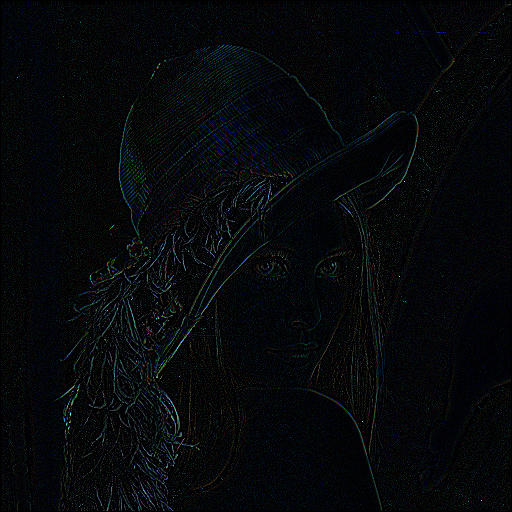

In [ ]:
from IPython.display import display
from PIL import Image
display(Image.open("lenna_fil_seq.ppm"))

### Análise de desempenho

In [ ]:
%%writefile laplacian_seq.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

typedef double matrix_type;
typedef matrix_type *matrix;

void fill_matrix(matrix m, int N)
{
    for (int i = 0; i < N; i++)
        for (int j = 0; j < N; j++)
            m[i * N + j] = (i + j + 2) * 1.;
    ;
}

void apply_filter(matrix m, matrix m_fil, int N)
{
    double delta_x, delta_y;
    for (int i = 1; i < (N - 1); i++)
        for (int j = 1; j < (N - 1); j++)
        {
            delta_x = 2 * m[i * N + j] + m[i * N + (j - 1)] + m[i * N + (j + 1)];
            delta_y = 2 * m[i * N + j] + m[(i - 1) * N + j] + m[(i + 1) * N + j];
            m_fil[i * N + j] = delta_x + delta_y;
        }
}

void write_filtered_matrix(matrix m_fil, int N)
{
    if (N > 10000)
    {
      printf("Tamanho de matriz muito grande para salvar em arquivo\n");
      return;
    }

    char file_name[51];
    sprintf(file_name, "laplacian_seq_m_fil_%d.txt", N);
    FILE *f_out = fopen(file_name, "w");
    for (int i = 0; i < N; i++)
    {
        for (int j = 0; j < N; j++)
            fprintf(f_out, "%lf ", m_fil[i * N + j]);
        fprintf(f_out, "\n");
    }
    fclose(f_out);
    printf("matriz filtrada salva em %s\n", file_name);
}

int main(int argc, char *argv[])
{
    int N = atoi(argv[1]);
    matrix m, m_fil;
    double t, t_total = 0;

    printf("%d:\n\t", N);

    m = (matrix)calloc(N * N, sizeof(matrix_type));
    m_fil = (matrix)calloc(N * N, sizeof(matrix_type));
    if (m == NULL || m_fil == NULL)
    {
        printf("Failed to allocate matrix of size %dX%d\n", N, N);
        return 1;
    }

    t = omp_get_wtime();
    fill_matrix(m, N);
    t = omp_get_wtime() - t;
    printf("fill_matrix\t%lf\n\t", t);
    t_total += t;

    t = omp_get_wtime();
    apply_filter(m, m_fil, N);
    t = omp_get_wtime() - t;
    printf("apply_filter\t%lf\n\t", t);
    t_total += t;

    printf("total time\t%lf\n\t", t_total);

    write_filtered_matrix(m_fil, N);

    free(m);
    free(m_fil);

    FILE *f_out = fopen("laplacian_seq_out.txt", "a");
    fprintf(f_out, "%lf, ", t_total);
    fclose(f_out);

    return 0;
}


Overwriting laplacian_seq.c


In [ ]:
!gcc laplacian_seq.c -o laplacian_seq -fopenmp
!OMP_NUM_THREADS=1 ./laplacian_seq 10000

10000:
	fill_matrix	0.699181
	apply_filter	1.148748
	total time	1.847930
	matriz filtrada salva em laplacian_seq_m_fil_10000.txt


In [ ]:
!cat laplacian_seq_m_fil_8.txt

0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 32.000000 40.000000 48.000000 56.000000 64.000000 72.000000 0.000000 
0.000000 40.000000 48.000000 56.000000 64.000000 72.000000 80.000000 0.000000 
0.000000 48.000000 56.000000 64.000000 72.000000 80.000000 88.000000 0.000000 
0.000000 56.000000 64.000000 72.000000 80.000000 88.000000 96.000000 0.000000 
0.000000 64.000000 72.000000 80.000000 88.000000 96.000000 104.000000 0.000000 
0.000000 72.000000 80.000000 88.000000 96.000000 104.000000 112.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 


In [ ]:
%%shell

gcc laplacian_seq.c -o laplacian_seq -fopenmp

echo -n '[' > laplacian_seq_out.txt
for i in 1024 4096 6144 8192 10240 14336 18432 22528; do
  echo -n "$i, " >> laplacian_seq_out.txt
done
echo ']' >> laplacian_seq_out.txt

echo -n '[' >> laplacian_seq_out.txt
for i in 1024 4096 6144 8192 10240 14336 18432 22528; do
  OMP_NUM_THREADS=1 ./laplacian_seq $i
done
echo ']' >> laplacian_seq_out.txt

1024:
	fill_matrix	0.007416
	apply_filter	0.014069
	total time	0.021485
	matriz filtrada salva em laplacian_seq_m_fil_1024.txt
4096:
	fill_matrix	0.140970
	apply_filter	0.816859
	total time	0.957828
	Tamanho de matriz muito grande para salvar em arquivo
6144:
	fill_matrix	0.920592
	apply_filter	1.251634
	total time	2.172226
	Tamanho de matriz muito grande para salvar em arquivo
8192:
	fill_matrix	0.906357
	apply_filter	2.356407
	total time	3.262764
	Tamanho de matriz muito grande para salvar em arquivo
10240:
	fill_matrix	1.346838
	apply_filter	3.398452
	total time	4.745289
	Tamanho de matriz muito grande para salvar em arquivo
14336:
	fill_matrix	2.510767
	apply_filter	4.911816
	total time	7.422583
	Tamanho de matriz muito grande para salvar em arquivo
18432:
	fill_matrix	2.688430
	apply_filter	6.768835
	total time	9.457265
	Tamanho de matriz muito grande para salvar em arquivo
22528:
	fill_matrix	3.829117
	apply_filter	9.425417
	total time	13.254534
	Tamanho de matriz muito grande pa

In [ ]:
%%writefile laplacian_seq_out.txt
[1024, 4096, 6144, 8192, 10240, 14336, 18432, 22528, ]
[0.010, 0.256, 0.610, 1.267, 1.686, 3.385, 6.912, 8.460, ]

Overwriting laplacian_seq_out.txt


In [ ]:
!cat laplacian_seq_out.txt

[1024, 4096, 6144, 8192, 10240, 14336, 18432, 22528, ]
[0.010, 0.256, 0.610, 1.267, 1.686, 3.385, 6.912, 8.460, ]


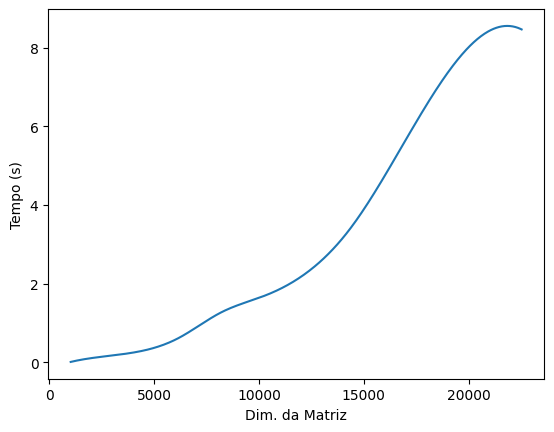

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

laplacian_seq_output = open("laplacian_seq_out.txt")
x = eval(laplacian_seq_output.readline())
x = np.array(x)
y = eval(laplacian_seq_output.readline())
y = np.array(y)

X_Y_Spline = make_interp_spline(x, y)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

plt.plot(X_, Y_)
plt.xlabel("Dim. da Matriz")
plt.ylabel("Tempo (s)")
plt.show()

## OMP

### filtragem de `lenna.ppm`

In [ ]:
%%writefile laplacian_lenna_omp.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

struct pixel
{
    unsigned char r, g, b;
};

void read_ppm_image(struct pixel **img, int *out_width, int *out_height)
{
    FILE *fd;
    char type[3];
    int rgb_max, actual_width, actual_height, i, j;

    fd = fopen("lenna.ppm", "r");
    if (fd == NULL)
    {
        printf("failed opening file lenna.ppm\n");
        exit(-1);
    }

    fscanf(fd, "%s", type);
    if (strcmp(type, "P3") != 0)
    {
        printf("wrong format. P3 format expected\n");
        exit(-1);
    }

    fscanf(fd, "%d %d", &actual_width, &actual_height);

    if ((*img = (struct pixel *)malloc(actual_height * actual_width * sizeof(struct pixel))) == NULL)
    {
        printf("failed allocating memory for %d pixels\n", actual_height * actual_width);
        exit(-1);
    }

    fscanf(fd, "%d", &rgb_max);

    for (i = 0; i < actual_height; i++)
        for (j = 0; j < actual_width; j++)
        {
            fscanf(fd, "%hhu", &((*img)[i * actual_height + j].r));
            fscanf(fd, "%hhu", &((*img)[i * actual_height + j].g));
            fscanf(fd, "%hhu", &((*img)[i * actual_height + j].b));
        }

    *out_width = actual_height;
    *out_height = actual_width;

    fclose(fd);
}

void write_ppm_image(char *file_name, struct pixel *img, int width, int height)
{
    FILE *fd;
    int rgb_max = 255, i, j;

    fd = fopen(file_name, "w");
    if (fd == NULL)
    {
        printf("failed opening file %s\n", file_name);
        exit(-1);
    }

    fprintf(fd, "P3\n");
    fprintf(fd, "%d %d\n", height, width);
    fprintf(fd, "%d\n", rgb_max);

    for (i = 0; i < height; i++)
    {
        for (j = 0; j < width; j++)
        {
            fprintf(fd, "%d ", img[i * height + j].r);
            fprintf(fd, "%d ", img[i * height + j].g);
            fprintf(fd, "%d ", img[i * height + j].b);
        }
        fprintf(fd, "\n");
    }

    fclose(fd);
}

int truncate_to_pixel(int value)
{
    if (value < 0)
        return 0;
    if (value > 255)
        return 255;
    return value;
}

void apply_filter(struct pixel *src_img, struct pixel *dst_img, int height, int width)
{
    int delta_x, delta_y;

    #pragma omp parallel for collapse(2) private(delta_x, delta_y)
    for (int i = 1; i < (height - 1); i++)
        for (int j = 1; j < (width - 1); j++)
        {
            delta_x = 2 * src_img[i * height + j].r - src_img[i * height + (j - 1)].r - src_img[i * height + (j + 1)].r;
            delta_y = 2 * src_img[i * height + j].r - src_img[(i - 1) * height + j].r - src_img[(i + 1) * height + j].r;
            dst_img[i * height + j].r = truncate_to_pixel(delta_x + delta_y);

            delta_x = 2 * src_img[i * height + j].g - src_img[i * height + (j - 1)].g - src_img[i * height + (j + 1)].g;
            delta_y = 2 * src_img[i * height + j].g - src_img[(i - 1) * height + j].g - src_img[(i + 1) * height + j].g;
            dst_img[i * height + j].g = truncate_to_pixel(delta_x + delta_y);

            delta_x = 2 * src_img[i * height + j].b - src_img[i * height + (j - 1)].b - src_img[i * height + (j + 1)].b;
            delta_y = 2 * src_img[i * height + j].b - src_img[(i - 1) * height + j].b - src_img[(i + 1) * height + j].b;
            dst_img[i * height + j].b = truncate_to_pixel(delta_x + delta_y);
        }
}

int main()
{
    struct pixel *src_img, *dst_img;
    int width, height;

    read_ppm_image(&src_img, &width, &height);

    if ((dst_img = (struct pixel *)calloc(height * width, sizeof(struct pixel))) == NULL)
    {
        printf("failed allocating memory %d pixels\n", height * width);
        exit(-1);
    }

    apply_filter(src_img, dst_img, height, width);

    write_ppm_image("lenna_fil_omp.ppm", dst_img, width, height);

    free(src_img);
    free(dst_img);

    printf("Imagem 'lenna.ppm' filtrada. Arquivo 'lenna_fil_omp.ppm' criado");
    return 0;
}


Writing laplacian_lenna_omp.c


In [ ]:
!gcc laplacian_lenna_omp.c -o laplacian_lenna_omp -fopenmp
!OMP_NUM_THREADS=2 ./laplacian_lenna_omp

Imagem 'lenna.ppm' filtrada. Arquivo 'lenna_fil_omp.ppm' criado

#### Imagem Filtrada

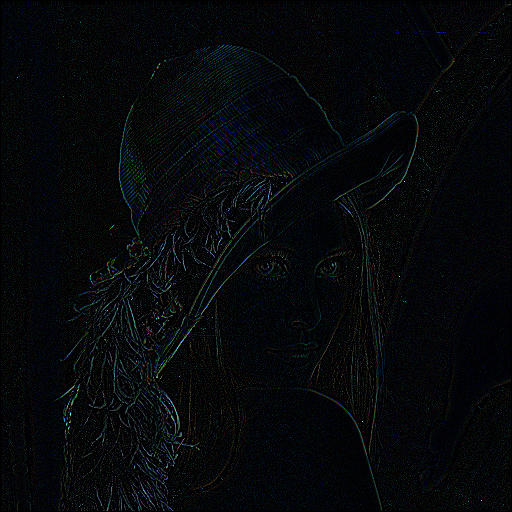

In [ ]:
from IPython.display import display
from PIL import Image
display(Image.open("lenna_fil_omp.ppm"))

### Análise de desempenho

In [ ]:
%%writefile laplacian_omp.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

typedef double matrix_type;
typedef matrix_type *matrix;

void fill_matrix(matrix m, int N)
{
    int i, j;
    #pragma omp parallel for collapse(2)
    for (i = 0; i < N; i++)
        for (j = 0; j < N; j++)
            m[i * N + j] = (i + j + 2) * 1.;
}

void apply_filter(matrix m, matrix m_fil, int N)
{
    double delta_x, delta_y;
    int i, j;

    #pragma omp parallel for collapse(2) private(delta_x, delta_y)
    for (i = 1; i < (N - 1); i++)
        for (j = 1; j < (N - 1); j++)
        {
            delta_x = 2 * m[i * N + j] + m[i * N + (j - 1)] + m[i * N + (j + 1)];
            delta_y = 2 * m[i * N + j] + m[(i - 1) * N + j] + m[(i + 1) * N + j];
            m_fil[i * N + j] = delta_x + delta_y;
        }
}

void write_filtered_matrix(matrix m_fil, int N)
{
    if (N > 10000)
    {
        printf("Tamanho de matriz muito grande para salvar em arquivo\n");
        return;
    }

    char file_name[51];
    sprintf(file_name, "laplacian_omp_m_fil_%d.txt", N);
    FILE *f_out = fopen(file_name, "w");
    int i, j;
    for (i = 0; i < N; i++)
    {
        for (j = 0; j < N; j++)
            fprintf(f_out, "%lf ", m_fil[i * N + j]);
        fprintf(f_out, "\n");
    }
    fclose(f_out);
    printf("matriz filtrada salva em %s\n", file_name);
}

int main(int argc, char *argv[])
{
    int N = atoi(argv[1]);
    matrix m, m_fil;
    double t, t_total = 0;

    printf("%d:\n\t", N);

    m = (matrix)calloc(N * N, sizeof(matrix_type));
    m_fil = (matrix)calloc(N * N, sizeof(matrix_type));
    if (m == NULL || m_fil == NULL)
    {
        printf("Failed to allocate matrix of size %dX%d\n", N, N);
        return 1;
    }

    t = omp_get_wtime();
    fill_matrix(m, N);
    t = omp_get_wtime() - t;
    printf("fill_matrix\t%lf\n\t", t);
    t_total += t;

    t = omp_get_wtime();
    apply_filter(m, m_fil, N);
    t = omp_get_wtime() - t;
    printf("apply_filter\t%lf\n\t", t);
    t_total += t;

    printf("total time\t%lf\n\t", t_total);

    write_filtered_matrix(m_fil, N);

    free(m);
    free(m_fil);

    FILE *f_out = fopen("laplacian_omp_out.txt", "a");
    fprintf(f_out, "%lf, ", t_total);
    fclose(f_out);

    return 0;
}


Writing laplacian_omp.c


In [ ]:
!gcc laplacian_omp.c -o laplacian_omp -fopenmp
!OMP_NUM_THREADS=2 ./laplacian_omp 10000

10000:
	fill_matrix	0.379934
	apply_filter	1.030482
	total time	1.410417
	matriz filtrada salva em laplacian_omp_m_fil_10000.txt


In [ ]:
!./compare_files.sh laplacian_omp_m_fil_10000.txt laplacian_seq_m_fil_10000.txt

O conteúdo dos arquivos é igual.


In [ ]:
%%shell

gcc laplacian_omp.c -o laplacian_omp -fopenmp

for i in 2 3 4; do
  echo -n "$i threads "
  OMP_NUM_THREADS=$i ./laplacian_omp 1024
done

2 threads 1024:
	fill_matrix	0.046406
	apply_filter	0.066361
	total time	0.112767
matriz filtrada salva em laplacian_omp_m_fil_1024.txt
3 threads 1024:
	fill_matrix	0.006699
	apply_filter	0.013099
	total time	0.019797
matriz filtrada salva em laplacian_omp_m_fil_1024.txt
4 threads 1024:
	fill_matrix	0.005657
	apply_filter	0.012767
	total time	0.018424
matriz filtrada salva em laplacian_omp_m_fil_1024.txt


In [ ]:
arq1 = open(arquivo_a, 'r')

## MPI

### filtragem de `lenna.ppm`

In [ ]:
%%writefile laplacian_lenna_mpi.c
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <stdbool.h>
#include <mpi.h>

#define MASTER 0

typedef struct pixel
{
    unsigned char r, g, b;
} pixel;

typedef pixel *matrix;

void read_ppm_image(struct pixel **img, int *out_width, int *out_height, int rank)
{
    FILE *fd;
    char type[3];
    int rgb_max, actual_width, actual_height, i, j;

    fd = fopen("lenna.ppm", "r");
    if (fd == NULL)
    {
        printf("failed opening file lenna.ppm\n");
        MPI_Abort(MPI_COMM_WORLD, EXIT_FAILURE);
    }

    fscanf(fd, "%s", type);
    if (strcmp(type, "P3") != 0)
    {
        printf("wrong format. P3 format expected\n");
        MPI_Abort(MPI_COMM_WORLD, EXIT_FAILURE);
    }

    fscanf(fd, "%d %d", &actual_width, &actual_height);

    int num_procs;
    MPI_Comm_size(MPI_COMM_WORLD, &num_procs);
    int lines_per_proc = 1 + (actual_height - 1) / num_procs;
    if (rank == MASTER)
        *img = (struct pixel *)calloc(actual_width * num_procs * lines_per_proc, sizeof(pixel));
    else
        *img = (struct pixel *)calloc(actual_width * (lines_per_proc + 2), sizeof(pixel));
    if (*img == NULL)
    {
        printf("Failed to allocate matrix on process %d\n", rank);
        MPI_Abort(MPI_COMM_WORLD, EXIT_FAILURE);
    }

    fscanf(fd, "%d", &rgb_max);

    unsigned char trash;
    int inf = rank * lines_per_proc, sup = inf + lines_per_proc;
    if (inf != 0)
        inf--;
    for (i = 0; i < actual_height; i++)
        if (i >= inf && i <= sup)
            for (j = 0; j < actual_width; j++)
            {
                fscanf(fd, "%hhu", &((*img)[(i - inf) * actual_height + j].r));
                fscanf(fd, "%hhu", &((*img)[(i - inf) * actual_height + j].g));
                fscanf(fd, "%hhu", &((*img)[(i - inf) * actual_height + j].b));
            }
        else
            for (j = 0; j < actual_width; j++)
            {
                fscanf(fd, "%hhu", &trash);
                fscanf(fd, "%hhu", &trash);
                fscanf(fd, "%hhu", &trash);
            }

    *out_width = actual_width;
    *out_height = actual_height;

    fclose(fd);
}

void write_ppm_image(char *file_name, struct pixel *img, int width, int height)
{
    FILE *fd;
    int rgb_max = 255, i, j;

    fd = fopen(file_name, "w");
    if (fd == NULL)
    {
        printf("failed opening file %s\n", file_name);
        exit(-1);
    }

    fprintf(fd, "P3\n");
    fprintf(fd, "%d %d\n", height, width);
    fprintf(fd, "%d\n", rgb_max);

    for (i = 0; i < height; i++)
    {
        for (j = 0; j < width; j++)
        {
            fprintf(fd, "%d ", img[i * height + j].r);
            fprintf(fd, "%d ", img[i * height + j].g);
            fprintf(fd, "%d ", img[i * height + j].b);
        }
        fprintf(fd, "\n");
    }

    fclose(fd);
}

int truncate_to_pixel(int value)
{
    if (value < 0)
        return 0;
    if (value > 255)
        return 255;
    return value;
}

void apply_filter(matrix src_img, matrix dst_img, int height, int width, int rank, int lines_per_proc)
{
    MPI_Status status;
    int inf = rank * lines_per_proc, sup = inf + lines_per_proc;
    int delta_x, delta_y;
    for (int i = 1; i < (height - 1); i++)
        if (i >= inf && i < sup)
        {
            bool inc = inf != 0;
            for (int j = 1; j < (width - 1); j++)
            {
                delta_x = 2 * src_img[(i + inc - inf) * height + j].r - src_img[(i + inc - inf) * height + (j - 1)].r - src_img[(i + inc - inf) * height + (j + 1)].r;
                delta_y = 2 * src_img[(i + inc - inf) * height + j].r - src_img[(i + inc - inf - 1) * height + j].r - src_img[(i + inc - inf + 1) * height + j].r;
                dst_img[(i - inf) * height + j].r = truncate_to_pixel(delta_x + delta_y);

                delta_x = 2 * src_img[(i + inc - inf) * height + j].g - src_img[(i + inc - inf) * height + (j - 1)].g - src_img[(i + inc - inf) * height + (j + 1)].g;
                delta_y = 2 * src_img[(i + inc - inf) * height + j].g - src_img[(i + inc - inf - 1) * height + j].g - src_img[(i + inc - inf + 1) * height + j].g;
                dst_img[(i - inf) * height + j].g = truncate_to_pixel(delta_x + delta_y);

                delta_x = 2 * src_img[(i + inc - inf) * height + j].b - src_img[(i + inc - inf) * height + (j - 1)].b - src_img[(i + inc - inf) * height + (j + 1)].b;
                delta_y = 2 * src_img[(i + inc - inf) * height + j].b - src_img[(i + inc - inf - 1) * height + j].b - src_img[(i + inc - inf + 1) * height + j].b;
                dst_img[(i - inf) * height + j].b = truncate_to_pixel(delta_x + delta_y);
            }
        }

    MPI_Gather(dst_img, 3 * width * lines_per_proc, MPI_UNSIGNED_CHAR, src_img, 3 * width * lines_per_proc, MPI_UNSIGNED_CHAR, MASTER, MPI_COMM_WORLD);
}

int main(int argc, char *argv[])
{
    int num_procs, rank;
    MPI_Init(&argc, &argv);
    MPI_Comm_size(MPI_COMM_WORLD, &num_procs);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);

    int width, height;
    matrix src_img, dst_img;

    read_ppm_image(&src_img, &width, &height, rank);
    // MPI_Barrier(MPI_COMM_WORLD);

    int lines_per_proc = 1 + (height - 1) / num_procs;
    dst_img = (matrix)calloc(width * lines_per_proc, sizeof(pixel));
    if (dst_img == NULL)
    {
        printf("Failed to allocate matrix on process %d\n", rank);
        MPI_Abort(MPI_COMM_WORLD, EXIT_FAILURE);
    }

    // Applies filter and overwrites it in src_img
    apply_filter(src_img, dst_img, height, width, rank, lines_per_proc);

    if (rank == MASTER)
    {
        write_ppm_image("lenna_fil_mpi.ppm", src_img, width, height);
        printf("Imagem 'lenna.ppm' filtrada. Arquivo 'lenna_fil_mpi.ppm' criado");
    }

    free(src_img);
    free(dst_img);

    MPI_Finalize();

    return 0;
}


Overwriting laplacian_lenna_mpi.c


In [ ]:
!mpicc laplacian_lenna_mpi.c -o laplacian_lenna_mpi
!mpirun --allow-run-as-root --oversubscribe -np 4 ./laplacian_lenna_mpi

Imagem 'lenna.ppm' filtrada. Arquivo 'lenna_fil_mpi.ppm' criado

#### Imagem Filtrada

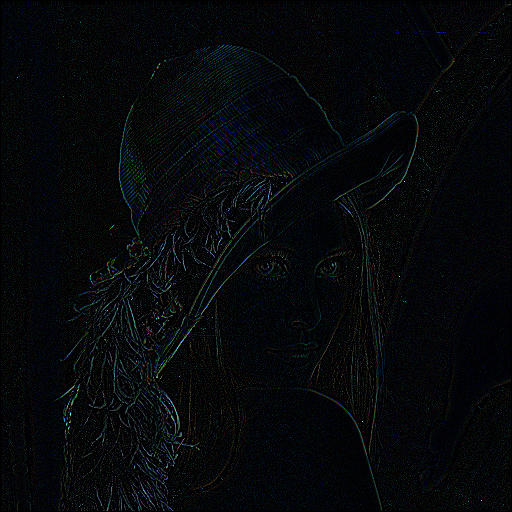

In [ ]:
from IPython.display import display
from PIL import Image
display(Image.open("lenna_fil_mpi.ppm"))

### Análise de Desempenho

In [ ]:
%%writefile laplacian_mpi.c
#include <stdio.h>
#include <stdlib.h>
#include <stdbool.h>
#include <mpi.h>
#include <omp.h>

#define MASTER 0

typedef double matriz_type;
typedef double *matrix;

void print_vector(matrix v, int N)
{
    for (int i = 0; i < N; i++)
        printf("%lf ", v[i]);
    printf("\n");
}

void fill_matrix(matrix m, int N, int rank, int lines_per_proc)
{
    int inf = rank * lines_per_proc, sup = inf + lines_per_proc;
    if (inf != 0)
        inf--;
    for (int i = 0; i < N; i++)
        if (i >= inf && i <= sup)
            for (int j = 0; j < N; j++)
                m[(i - inf) * N + j] = (i + j + 2) * 1.;
}

void apply_filter(matrix m, matrix m_fil, int N, int rank, int lines_per_proc)
{
    MPI_Status status;
    int inf = rank * lines_per_proc, sup = inf + lines_per_proc;
    double delta_x, delta_y;
    for (int i = 1; i < (N - 1); i++)
        if (i >= inf && i < sup)
        {
            bool inc = inf != 0;
            for (int j = 1; j < (N - 1); j++)
            {
                delta_x = 2 * m[(i + inc - inf) * N + j] + m[(i + inc - inf) * N + (j - 1)] + m[(i + inc - inf) * N + (j + 1)];
                delta_y = 2 * m[(i + inc - inf) * N + j] + m[(i + inc - inf - 1) * N + j] + m[(i + inc - inf + 1) * N + j];
                m_fil[(i - inf) * N + j] = delta_x + delta_y;
            }
        }

    MPI_Gather(m_fil, N * lines_per_proc, MPI_DOUBLE, m, N * lines_per_proc, MPI_DOUBLE, MASTER, MPI_COMM_WORLD);
}

void write_filtered_matrix(matrix m_fil, int N)
{
    if (N > 10000)
    {
        printf("Tamanho de matriz muito grande para salvar em arquivo\n");
        return;
    }

    char file_name[51];
    sprintf(file_name, "laplacian_mpi_m_fil_%d.txt", N);
    FILE *f_out = fopen(file_name, "w");
    for (int i = 0; i < N; i++)
    {
        for (int j = 0; j < N; j++)
            fprintf(f_out, "%lf ", m_fil[i * N + j]);
        fprintf(f_out, "\n");
    }
    fclose(f_out);
    printf("matriz filtrada salva em %s\n", file_name);
}

int main(int argc, char *argv[])
{
    // Initializes MPI environment
    int rank;
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);

    int N = atoi(argv[1]);
    matrix m = NULL, m_fil = NULL;
    double t = 0, t_total = 0;

    int num_procs;
    MPI_Comm_size(MPI_COMM_WORLD, &num_procs);
    int lines_per_proc = 1 + (N - 1) / num_procs;

    if (rank == MASTER)
        printf("%d:\n\t", N);

    if (rank == MASTER)
        m = (matrix)calloc(N * num_procs * lines_per_proc, sizeof(matriz_type));
    else
        m = (matrix)calloc(N * (lines_per_proc + 2), sizeof(matriz_type));
    m_fil = (matrix)calloc(N * lines_per_proc, sizeof(matriz_type));
    if (m == NULL || m_fil == NULL)
    {
        printf("Failed to allocate matrix on process %d\n", rank);
        MPI_Abort(MPI_COMM_WORLD, EXIT_FAILURE);
    }

    t = omp_get_wtime();
    fill_matrix(m, N, rank, lines_per_proc);
    t = omp_get_wtime() - t;
    if (rank == MASTER)
        printf("fill_matrix\t%lf\n\t", t);
    t_total += t;

    /*printf("%d: ", rank);
    print_vector(m, N * (lines_per_proc + 2));
    MPI_Barrier(MPI_COMM_WORLD);
    return 1;*/

    t = omp_get_wtime();
    apply_filter(m, m_fil, N, rank, lines_per_proc);
    t = omp_get_wtime() - t;
    if (rank == MASTER)
        printf("apply_filter\t%lf\n\t", t);
    t_total += t;

    if (rank == MASTER)
    {
        printf("total time\t%lf\n\t", t_total);
        write_filtered_matrix(m, N);
    }

    free(m);
    free(m_fil);

    if (rank == MASTER)
    {
        FILE *f_out = fopen("laplacian_mpi_out.txt", "a");
        fprintf(f_out, "%lf, ", t_total);
        fclose(f_out);
    }

    MPI_Finalize();

    return 0;
}


Overwriting laplacian_mpi.c


In [ ]:
!mpicc -fopenmp laplacian_mpi.c -o laplacian_mpi
!export OMP_NUM_THREADS=1
!mpirun --allow-run-as-root --oversubscribe -np 2 ./laplacian_mpi 10000

10000:
	fill_matrix	0.396535
	apply_filter	1.561742
	total time	1.958277
	matriz filtrada salva em laplacian_mpi_m_fil_10000.txt


In [ ]:
!./compare_files.sh laplacian_mpi_m_fil_10000.txt laplacian_seq_m_fil_10000.txt

O conteúdo dos arquivos é igual.


In [ ]:
%%shell

mpicc -fopenmp laplacian_mpi.c -o laplacian_mpi
export OMP_NUM_THREADS=1

for i in 2 3 4 5; do
  echo -n "$i processes "
  mpirun --allow-run-as-root --oversubscribe -np $i ./laplacian_mpi 14336
done

2 processes 14336:
	fill_matrix	2.933328
	apply_filter	4.569019
	total time	7.502347
	Tamanho de matriz muito grande para salvar em arquivo
3 processes 14336:
	fill_matrix	0.916458
	apply_filter	5.636309
	total time	6.552768
	Tamanho de matriz muito grande para salvar em arquivo
4 processes 14336:
	fill_matrix	1.569684
	apply_filter	4.556316
	total time	6.126000
	Tamanho de matriz muito grande para salvar em arquivo
5 processes 14336:
	fill_matrix	0.950934
	apply_filter	6.138071
	total time	7.089005
	Tamanho de matriz muito grande para salvar em arquivo


## CUDA

### filtragem de `lenna.ppm`

In [ ]:
%%writefile laplacian_lenna_cuda.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <cuda.h>

struct pixel
{
    unsigned char r, g, b;
};

void read_ppm_image(struct pixel **img, int *p_width, int *p_height)
{
    FILE *fd;
    char type[3];
    int rgb_max;

    fd = fopen("lenna.ppm", "r");
    if (fd == NULL)
    {
        printf("failed opening file lenna.ppm\n");
        exit(-1);
    }

    fscanf(fd, "%s", type);
    if (strcmp(type, "P3") != 0)
    {
        printf("wrong format. P3 format expected\n");
        exit(-1);
    }

    fscanf(fd, "%d %d", p_width, p_height);

    int width = *p_width, height = *p_height;
    cudaMallocManaged(img, sizeof(struct pixel) * width * height);

    fscanf(fd, "%d", &rgb_max);

    for (int i = 0; i < height; i++)
        for (int j = 0; j < width; j++)
        {
            fscanf(fd, "%hhu", &((*img)[i * height + j].r));
            fscanf(fd, "%hhu", &((*img)[i * height + j].g));
            fscanf(fd, "%hhu", &((*img)[i * height + j].b));
        }

    fclose(fd);
}

void write_ppm_image(char *file_name, struct pixel *img, int width, int height)
{
    FILE *fd;

    fd = fopen(file_name, "w");
    if (fd == NULL)
    {
        printf("failed opening file %s\n", file_name);
        exit(-1);
    }

    fprintf(fd, "P3\n");
    fprintf(fd, "%d %d\n", height, width);
    fprintf(fd, "255\n");

    for (int i = 0; i < height; i++)
    {
        for (int j = 0; j < width; j++)
        {
            fprintf(fd, "%d ", img[i * height + j].r);
            fprintf(fd, "%d ", img[i * height + j].g);
            fprintf(fd, "%d ", img[i * height + j].b);
        }
        fprintf(fd, "\n");
    }

    fclose(fd);
}

__device__ int truncate_to_pixel(int value)
{
    if (value < 0)
        return 0;
    if (value > 255)
        return 255;
    return value;
}

__global__ void apply_filter(struct pixel *src_img, struct pixel *dst_img, int height, int width)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    if (i < height && j < width)
    {
        if (i == 0 || j == 0 || i == height - 1 || j == width - 1)
        {
            dst_img[i * height + j].r = 0;
            dst_img[i * height + j].g = 0;
            dst_img[i * height + j].b = 0;
        }
        else
        {
            int delta_x, delta_y;

            delta_x = 2 * src_img[i * height + j].r - src_img[i * height + (j - 1)].r - src_img[i * height + (j + 1)].r;
            delta_y = 2 * src_img[i * height + j].r - src_img[(i - 1) * height + j].r - src_img[(i + 1) * height + j].r;
            dst_img[i * height + j].r = truncate_to_pixel(delta_x + delta_y);

            delta_x = 2 * src_img[i * height + j].g - src_img[i * height + (j - 1)].g - src_img[i * height + (j + 1)].g;
            delta_y = 2 * src_img[i * height + j].g - src_img[(i - 1) * height + j].g - src_img[(i + 1) * height + j].g;
            dst_img[i * height + j].g = truncate_to_pixel(delta_x + delta_y);

            delta_x = 2 * src_img[i * height + j].b - src_img[i * height + (j - 1)].b - src_img[i * height + (j + 1)].b;
            delta_y = 2 * src_img[i * height + j].b - src_img[(i - 1) * height + j].b - src_img[(i + 1) * height + j].b;
            dst_img[i * height + j].b = truncate_to_pixel(delta_x + delta_y);
        }
    }
}

int main()
{
    struct pixel *src_img, *dst_img;
    int width, height;

    read_ppm_image(&src_img, &width, &height);

    cudaMallocManaged(&dst_img, sizeof(struct pixel) * width * height);

    dim3 gridDim(1 + (height - 1) / 32, 1 + (width - 1) / 32);
    dim3 blockDim(32, 32);
    apply_filter<<<gridDim, blockDim>>>(src_img, dst_img, height, width);
    cudaDeviceSynchronize();

    write_ppm_image("lenna_fil_cuda.ppm", dst_img, width, height);

    cudaFree(src_img);
    cudaFree(dst_img);

    printf("Imagem 'lenna.ppm' filtrada. Arquivo 'lenna_fil_cuda.ppm' criado");
    return 0;
}


Overwriting laplacian_lenna_cuda.cu


In [ ]:
!nvcc -o laplacian_lenna_cuda laplacian_lenna_cuda.cu
!./laplacian_lenna_cuda

laplacian_lenna_cuda.cu(132): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_lenna_cuda.cu(132): warning #2464-D: conversion from a string literal to "char *" is deprecated

Imagem 'lenna.ppm' filtrada. Arquivo 'lenna_fil_cuda.ppm' criado

#### Imagem Filtrada

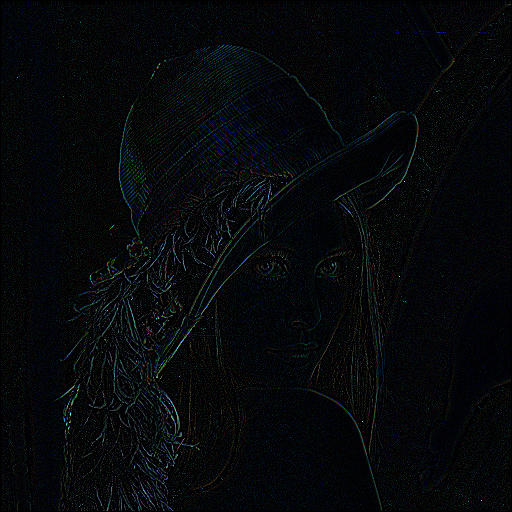

In [ ]:
from IPython.display import display
from PIL import Image
display(Image.open("lenna_fil_cuda.ppm"))

### Análise de Desempenho

In [ ]:
%%writefile laplacian_cuda.cu
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
#include <cuda.h>

typedef double matrix_type;
typedef matrix_type *matrix;

#define check_cuda_err(val)               \
    {                                     \
        check((val), __FILE__, __LINE__); \
    }
void check(cudaError_t code, char *file, int line)
{
    if (code != cudaSuccess)
    {
        fprintf(stderr, "GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
        exit(code);
    }
}

__global__ void fill_matrix(matrix m, int N)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i < N && j < N)
        m[i * N + j] = (i + j + 2) * 1.;
}

__global__ void apply_filter(matrix m, matrix m_fil, int N)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;

    if (i < N && j < N)
    {
        if (i == 0 || j == 0 || i == N - 1 || j == N - 1)
            m_fil[i * N + j] = 0;
        else
        {
            double delta_x, delta_y;
            delta_x = 2 * m[i * N + j] - m[i * N + (j - 1)] - m[i * N + (j + 1)];
            delta_y = 2 * m[i * N + j] - m[(i - 1) * N + j] - m[(i + 1) * N + j];
            m_fil[i * N + j] = delta_x + delta_y;
        }
    }
}

void write_filtered_matrix(matrix m_fil, int N)
{
    if (N > 1024)
    {
        printf("Tamanho de matriz muito grande para salvar em arquivo\n");
        return;
    }

    char file_name[51];
    sprintf(file_name, "laplacian_cuda_m_fil_%d.txt", N);
    FILE *f_out = fopen(file_name, "w");
    for (int i = 0; i < N; i++)
    {
        for (int j = 0; j < N; j++)
            fprintf(f_out, "%lf ", m_fil[i * N + j]);
        fprintf(f_out, "\n");
    }
    fclose(f_out);
    printf("matriz filtrada salva em %s\n", file_name);
}

int main(int argc, char *argv[])
{
    int N = atoi(argv[1]);
    matrix m, m_fil;
    double t, t_total = 0;

    printf("%d:\n\t", N);

    check_cuda_err(cudaMallocManaged((void **)&m, N * N * sizeof(matrix_type)));
    check_cuda_err(cudaMallocManaged((void **)&m_fil, N * N * sizeof(matrix_type)));

    dim3 gridDim(1 + (N - 1) / 32, 1 + (N - 1) / 32);
    dim3 blockDim(32, 32);

    t = omp_get_wtime();
    fill_matrix<<<gridDim, blockDim>>>(m, N);
    t = omp_get_wtime() - t;
    t_total += t;
    printf("fill_matrix\t%lf\n\t", t);

    t = omp_get_wtime();
    apply_filter<<<gridDim, blockDim>>>(m, m_fil, N);
    check_cuda_err(cudaPeekAtLastError());
    check_cuda_err(cudaDeviceSynchronize());
    t = omp_get_wtime() - t;
    t_total += t;
    printf("apply_filter\t%lf\n\t", t);

    printf("total time\t%lf\n", t_total);

    write_filtered_matrix(m_fil, N);

    cudaFree(m);
    cudaFree(m_fil);

    FILE *f_out = fopen("laplacian_cuda_out.txt", "a");
    fprintf(f_out, "%lf, ", t_total);
    fclose(f_out);

    return 0;
}


Overwriting laplacian_cuda.cu


In [ ]:
!nvcc -Xcompiler -fopenmp laplacian_cuda.cu -o laplacian_cuda
!OMP_NUM_THREADS=1 ./laplacian_cuda 1024

laplacian_cuda.cu(79): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda.cu(80): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda.cu(93): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda.cu(94): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda.cu(79): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda.cu(80): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda.cu(93): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda.cu(94): warning #2464-D: conversion from a string literal to "char *" is deprecated

1024:
	fill_matrix	0.000022
	apply_filter	0.002323
	total time	0.002345
matriz filtrada salva em laplacian_cuda_m_fil_1024.txt


In [ ]:
!./compare_files.sh laplacian_cuda_m_fil_1024.txt laplacian_seq_m_fil_1024.txt

O conteúdo dos arquivos é diferente:


In [ ]:
%%shell

nvcc -Xcompiler -fopenmp laplacian_cuda.cu -o laplacian_cuda

echo -n '[' > laplacian_cuda_out.txt
for i in 1024 4096 6144 8192 10240 14336 18432 22528; do
  echo -n "$i, " >> laplacian_cuda_out.txt
done
echo ']' >> laplacian_cuda_out.txt

echo -n '[' >> laplacian_cuda_out.txt
for i in 1024 4096 6144 8192 10240 14336 18432 22528; do
  OMP_NUM_THREADS=1 ./laplacian_cuda $i
done
echo ']' >> laplacian_cuda_out.txt


laplacian_cuda.cu(79): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda.cu(80): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda.cu(93): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda.cu(94): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda.cu(79): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda.cu(80): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda.cu(93): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda.cu(94): warning #2464-D: conversion from a string literal to "char *" is deprecated

1024:
	fill_matrix	0.000027
	apply_filter	0.001331
	total time	0.001358
matriz filtrada salva em laplacian_cuda_m_fil_1024.txt
4096:
	fill_matrix	0.000023
	apply_filter	0.033955
	total time	0.033978
T

CalledProcessError: ignored

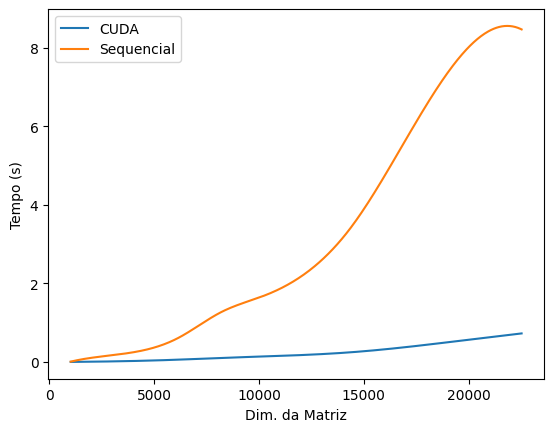

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

output = open("laplacian_cuda_out.txt")
x = eval(output.readline())
x = np.array(x)
y = eval(output.readline())
y = np.array(y)

X_Y_Spline = make_interp_spline(x, y)
X_CUDA = np.linspace(x.min(), x.max(), 500)
Y_CUDA = X_Y_Spline(X_)

output = open("laplacian_seq_out.txt")
x = eval(output.readline())
x = np.array(x)
y = eval(output.readline())
y = np.array(y)

X_Y_Spline = make_interp_spline(x, y)
X_SEQ = np.linspace(x.min(), x.max(), 500)
Y_SEQ = X_Y_Spline(X_SEQ)

plt.plot(X_CUDA, Y_CUDA, label='CUDA')
plt.plot(X_SEQ, Y_SEQ, label='Sequencial')
plt.legend()
plt.xlabel("Dim. da Matriz")
plt.ylabel("Tempo (s)")
plt.show()

[4.108463434675431, 9.39690929780127, 10.228206375023056, 12.210988926261816, 11.902408719961596, 13.757981458224101, 14.836693340660094, 11.6321277719113]


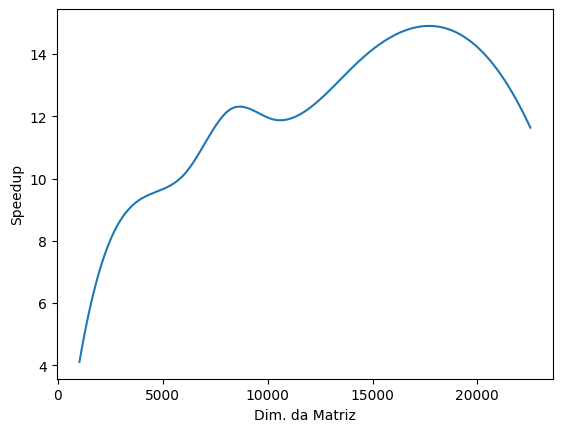

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

output = open("laplacian_cuda_out.txt")
x = eval(output.readline())
x = np.array(x)
y = eval(output.readline())
y_cuda = np.array(y)

output = open("laplacian_seq_out.txt")
output.readline()
y = eval(output.readline())
y_seq = np.array(y)

y_speedup = []
for i in range(len(x)):
  y_speedup.append(y_seq[i] / y_cuda[i])
print(y_speedup)

X_Y_Spline = make_interp_spline(x, y_speedup)
X_SPEEDUP = np.linspace(x.min(), x.max(), 500)
Y_SPEEDUP = X_Y_Spline(X_SPEEDUP)

plt.plot(X_SPEEDUP, Y_SPEEDUP)
plt.xlabel("Dim. da Matriz")
plt.ylabel("Speedup")
plt.show()

## Temp

In [ ]:
!nvidia-smi

Sat Nov 25 00:42:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%writefile laplacian_cuda_temp.cu
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
#include <cuda.h>
#include <cuda_runtime.h>

typedef double matrix_type;
typedef matrix_type *matrix;

#define check_cuda_err(val)               \
    {                                     \
        check((val), __FILE__, __LINE__); \
    }
void check(cudaError_t code, char *file, int line)
{
    if (code != cudaSuccess)
    {
        fprintf(stderr, "GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
        exit(code);
    }
}

__global__ void fill_matrix(matrix m, int N)
{
    unsigned int idx = blockIdx.x * blockDim.x + threadIdx.x;
    unsigned int stride = gridDim.x * blockDim.x;
    for (; idx < N * N; idx += stride)
    {
        unsigned int i = idx / N;
        unsigned int j = idx - N * i;
        m[i * N + j] = (i + j + 2) * 1.;
    }
}

__global__ void apply_filter(matrix m, matrix m_fil, int N)
{
    unsigned int idx = blockIdx.x * blockDim.x + threadIdx.x;
    unsigned int stride = gridDim.x * blockDim.x;
    for (; idx < N * N; idx += stride)
    {
        unsigned int i = idx / N;
        unsigned int j = idx - N * i;
        if (i == 0 || j == 0 || i == N - 1 || j == N - 1)
            m_fil[i * N + j] = 0;
        else
        {
            double delta_x, delta_y;
            delta_x = 2 * m[i * N + j] + m[i * N + (j - 1)] + m[i * N + (j + 1)];
            delta_y = 2 * m[i * N + j] + m[(i - 1) * N + j] + m[(i + 1) * N + j];
            m_fil[i * N + j] = delta_x + delta_y;
        }
    }
}

void write_filtered_matrix(matrix m_fil, int N)
{
    if (N > 1024)
    {
        printf("Tamanho de matriz muito grande para salvar em arquivo\n");
        return;
    }

    char file_name[51];
    sprintf(file_name, "laplacian_cuda_atual_m_fil_%d.txt", N);
    FILE *f_out = fopen(file_name, "w");
    for (int i = 0; i < N; i++)
    {
        for (int j = 0; j < N; j++)
            fprintf(f_out, "%lf ", m_fil[i * N + j]);
        fprintf(f_out, "\n");
    }
    fclose(f_out);
    printf("matriz filtrada salva em %s\n", file_name);
}

int main(int argc, char *argv[])
{
    int N = atoi(argv[1]);
    matrix m, m_fil;
    double t, t_total = 0;

    int device_id;
    cudaGetDevice(&device_id);
    cudaDeviceProp props;
    cudaGetDeviceProperties(&props, device_id);
    int num_blocks = props.multiProcessorCount * props.maxBlocksPerMultiProcessor;
    int num_threads = min(props.maxThreadsPerMultiProcessor, props.maxThreadsPerBlock);
    printf("device id: %d\n", device_id);
    printf("mp count: %d\n", props.multiProcessorCount);
    printf("max blocks per mp: %d\n", props.maxBlocksPerMultiProcessor);
    printf("max threads per mp: %d\n", props.maxThreadsPerMultiProcessor);
    printf("max threads per bloc: %d\n", props.maxThreadsPerBlock);
    printf("num_blocks: %d\n", num_blocks);
    printf("num_threads: %d\n", num_threads);
    check_cuda_err(cudaPeekAtLastError());

    printf("%d:\n\t", N);

    check_cuda_err(cudaMallocManaged((void **)&m, N * N * sizeof(matrix_type)));
    check_cuda_err(cudaMallocManaged((void **)&m_fil, N * N * sizeof(matrix_type)));

    t = omp_get_wtime();
    fill_matrix<<<num_blocks, num_threads>>>(m, N);
    check_cuda_err(cudaPeekAtLastError());
    t = omp_get_wtime() - t;
    t_total += t;
    printf("fill_matrix\t%lf\n\t", t);

    t = omp_get_wtime();
    apply_filter<<<num_blocks, num_threads>>>(m, m_fil, N);
    check_cuda_err(cudaPeekAtLastError());
    check_cuda_err(cudaDeviceSynchronize());
    t = omp_get_wtime() - t;
    t_total += t;
    printf("apply_filter\t%lf\n\t", t);

    printf("total time\t%lf\n\t", t_total);

    write_filtered_matrix(m_fil, N);

    cudaFree(m);
    cudaFree(m_fil);

    FILE *f_out = fopen("laplacian_cuda_out.txt", "a");
    fprintf(f_out, "%lf, ", t_total);
    fclose(f_out);

    return 0;
}


Overwriting laplacian_cuda_temp.cu


In [ ]:
!nvcc -Xcompiler -fopenmp laplacian_cuda_temp.cu -o laplacian_cuda_temp
!OMP_NUM_THREADS=1 ./laplacian_cuda_temp 27648

laplacian_cuda_temp.cu(95): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(99): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(100): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(104): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(111): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(112): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(95): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(99): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(100): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(104): warning #2464-D: conv

In [ ]:
!cat laplacian_cuda_m_fil_8.txt

0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 
0.000000 32.000000 40.000000 48.000000 56.000000 64.000000 72.000000 0.000000 
0.000000 40.000000 48.000000 56.000000 64.000000 72.000000 80.000000 0.000000 
0.000000 48.000000 56.000000 64.000000 72.000000 80.000000 88.000000 0.000000 
0.000000 56.000000 64.000000 72.000000 80.000000 88.000000 96.000000 0.000000 
0.000000 64.000000 72.000000 80.000000 88.000000 96.000000 104.000000 0.000000 
0.000000 72.000000 80.000000 88.000000 96.000000 104.000000 112.000000 0.000000 
0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 


In [ ]:
!./compare_files.sh laplacian_cuda_temp_m_fil_1024.txt laplacian_seq_m_fil_1024.txt

O conteúdo dos arquivos é igual.


In [ ]:
%%shell

nvcc -Xcompiler -fopenmp laplacian_cuda_temp.cu -o laplacian_cuda_temp

echo -n '[' > laplacian_cuda_temp.txt
for i in 1024 4096 6144 8192 10240 14336 18432 22528; do
  echo -n "$i, " >> laplacian_cuda_temp.txt
done
echo ']' >> laplacian_cuda_temp.txt

echo -n '[' >> laplacian_cuda_temp.txt
for i in 1024 4096 6144 8192 10240 14336 18432 22528; do
  OMP_NUM_THREADS=1 ./laplacian_cuda_temp $i
done
echo ']' >> laplacian_cuda_temp.txt


laplacian_cuda_temp.cu(95): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(99): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(100): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(104): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(111): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(112): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(95): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(99): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(100): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_cuda_temp.cu(104): warning #2464-D: conv

In [ ]:
%%writefile laplacian_lenna_cuda_temp.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <cuda.h>
#include <cuda_runtime.h>

struct pixel
{
    unsigned char r, g, b;
};

void read_ppm_image(struct pixel **img, int *p_width, int *p_height)
{
    FILE *fd;
    char type[3];
    int rgb_max;

    fd = fopen("lenna.ppm", "r");
    if (fd == NULL)
    {
        printf("failed opening file lenna.ppm\n");
        exit(-1);
    }

    fscanf(fd, "%s", type);
    if (strcmp(type, "P3") != 0)
    {
        printf("wrong format. P3 format expected\n");
        exit(-1);
    }

    fscanf(fd, "%d %d", p_width, p_height);

    int width = *p_width, height = *p_height;
    cudaMallocManaged(img, sizeof(struct pixel) * width * height);

    fscanf(fd, "%d", &rgb_max);

    for (int i = 0; i < height; i++)
        for (int j = 0; j < width; j++)
        {
            fscanf(fd, "%hhu", &((*img)[i * height + j].r));
            fscanf(fd, "%hhu", &((*img)[i * height + j].g));
            fscanf(fd, "%hhu", &((*img)[i * height + j].b));
        }

    fclose(fd);
}

void write_ppm_image(char *file_name, struct pixel *img, int width, int height)
{
    FILE *fd;

    fd = fopen(file_name, "w");
    if (fd == NULL)
    {
        printf("failed opening file %s\n", file_name);
        exit(-1);
    }

    fprintf(fd, "P3\n");
    fprintf(fd, "%d %d\n", height, width);
    fprintf(fd, "255\n");

    for (int i = 0; i < height; i++)
    {
        for (int j = 0; j < width; j++)
        {
            fprintf(fd, "%d ", img[i * height + j].r);
            fprintf(fd, "%d ", img[i * height + j].g);
            fprintf(fd, "%d ", img[i * height + j].b);
        }
        fprintf(fd, "\n");
    }

    fclose(fd);
}

__device__ int truncate_to_pixel(int value)
{
    if (value < 0)
        return 0;
    if (value > 255)
        return 255;
    return value;
}

__global__ void apply_filter(struct pixel *src_img, struct pixel *dst_img, int height, int width)
{
    unsigned int idx = blockIdx.x * blockDim.x + threadIdx.x;
    unsigned int stride = gridDim.x * blockDim.x;

    for (; idx < height * width; idx += stride)
    {
        unsigned int i = idx / height;
        unsigned int j = idx - height * i;

        if (i == 0 || j == 0 || i == height - 1 || j == width - 1)
        {
            dst_img[i * height + j].r = 0;
            dst_img[i * height + j].g = 0;
            dst_img[i * height + j].b = 0;
        }
        else
        {
            int delta_x, delta_y;

            delta_x = 2 * src_img[i * height + j].r - src_img[i * height + (j - 1)].r - src_img[i * height + (j + 1)].r;
            delta_y = 2 * src_img[i * height + j].r - src_img[(i - 1) * height + j].r - src_img[(i + 1) * height + j].r;
            dst_img[i * height + j].r = truncate_to_pixel(delta_x + delta_y);

            delta_x = 2 * src_img[i * height + j].g - src_img[i * height + (j - 1)].g - src_img[i * height + (j + 1)].g;
            delta_y = 2 * src_img[i * height + j].g - src_img[(i - 1) * height + j].g - src_img[(i + 1) * height + j].g;
            dst_img[i * height + j].g = truncate_to_pixel(delta_x + delta_y);

            delta_x = 2 * src_img[i * height + j].b - src_img[i * height + (j - 1)].b - src_img[i * height + (j + 1)].b;
            delta_y = 2 * src_img[i * height + j].b - src_img[(i - 1) * height + j].b - src_img[(i + 1) * height + j].b;
            dst_img[i * height + j].b = truncate_to_pixel(delta_x + delta_y);
        }
    }
}

int main()
{
    struct pixel *src_img, *dst_img;
    int width, height;

    int device_id;
    cudaGetDevice(&device_id);
    cudaDeviceProp props;
    cudaGetDeviceProperties(&props, device_id);
    printf("device id: %d\n", device_id);
    printf("mp count: %d\n", props.multiProcessorCount);
    printf("max blocks per mp: %d\n", props.maxBlocksPerMultiProcessor);
    printf("max threads per mp: %d\n", props.maxThreadsPerMultiProcessor);
    printf("max threads per bloc: %d\n", props.maxThreadsPerBlock);

    read_ppm_image(&src_img, &width, &height);

    cudaMallocManaged(&dst_img, sizeof(struct pixel) * width * height);

    int num_blocks = props.multiProcessorCount * props.maxBlocksPerMultiProcessor;
    int threads_per_bloc = props.maxThreadsPerMultiProcessor;
    apply_filter<<<num_blocks, threads_per_bloc>>>(src_img, dst_img, height, width);
    cudaDeviceSynchronize();

    write_ppm_image("lenna_fil_cuda_temp.ppm", dst_img, width, height);

    cudaFree(src_img);
    cudaFree(dst_img);

    printf("Imagem 'lenna.ppm' filtrada. Arquivo 'lenna_fil_cuda_temp.ppm' criado");
    return 0;
}


Overwriting laplacian_lenna_cuda_temp.cu


In [ ]:
!nvcc -o laplacian_lenna_cuda_temp laplacian_lenna_cuda_temp.cu
!./laplacian_lenna_cuda_temp

laplacian_lenna_cuda_temp.cu(147): warning #2464-D: conversion from a string literal to "char *" is deprecated

laplacian_lenna_cuda_temp.cu(147): warning #2464-D: conversion from a string literal to "char *" is deprecated

device id: 0
mp count: 40
max blocks per mp: 16
max threads per mp: 1024
max threads per bloc: 1024
Imagem 'lenna.ppm' filtrada. Arquivo 'lenna_fil_cuda_temp.ppm' criado

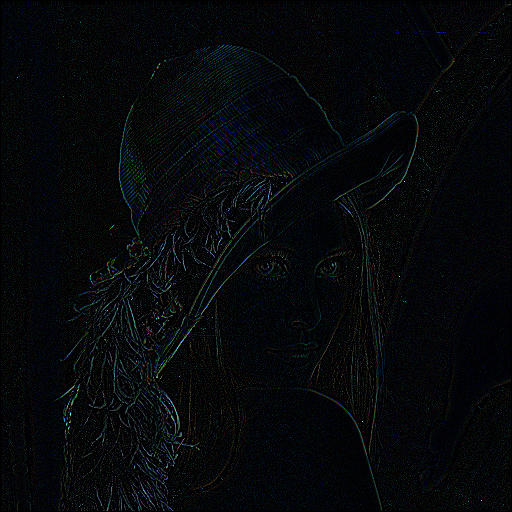

In [ ]:
from IPython.display import display
from PIL import Image
display(Image.open("lenna_fil_cuda_temp.ppm"))

## Temp2

In [ ]:
%%writefile temp2.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <math.h>
#include <omp.h>
#include <cuda.h>

__global__ void populationMatrix2D(double *a, int rows, int jsta, int jend) {
    int j = blockIdx.x * blockDim.x + threadIdx.x;
    if (j < jend) {
        for (int i = 0; i < rows; i++) {
            a[i + j * rows] = (i + j + 2) * 1.0;
        }
    }
}

void showMatrix(double *a, int n) {
    for (int i = 0; i < n; i++) {
        for (int j = 0; j < n; j++) {
            printf("%1.2f\t", a[i + j * n]);
        }
        printf("\n");
    }
    printf("\n");
}

void showVector(int *a, int n) {
    for (int i = 0; i < n; i++)
        printf("%d\t", a[i]);
    printf("\n\n");
}

__global__ void kernel(double *a, double *c, int m, int n, int jsta2, int jend2, int dx, int dz) {
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    if (j >= jsta2 && j < jend2) {
        for (int i = 1; i < (m - 1); i++) {
            double sx = a[(i - 1) + j * n] + a[(i + 1) + j * n] + 2 * a[i + j * n];
            double sz = a[i + (j - 1) * n] + a[i + (j + 1) * n] + 2 * a[i + j * n];
            c[i + j * n] = (sx / (dx * dx)) + (sz / (dz * dz));
        }
    }
}


void PARA_RANGE(int n1, int n2, int nprocs, int myid, int jsta, int jend, int *vector_return) {
    int iwork1 = (n2 - n1 + 1) / nprocs;
    int iwork2 = (n2 - n1 + 1) % nprocs;

    jsta = (myid * iwork1) + n1 + fmin((double)myid, (double)iwork2);
    jend = jsta + iwork1 - 1;

    if (iwork2 > myid)
        jend = jend + 1;

    vector_return[0] = jsta;
    vector_return[1] = jend;
}

int main(int argc, char *argv[]) {
    int rows = atoi(argv[1]);
    int columns = rows;
    int myid = 0;
    int nprocs = 1;
    double dx = 1, dz = 1;
    int jsta = 1, jend = 1, jsta2, jend2;
    int *vector_return = (int *)calloc(2, sizeof(int));
    double t1, t2;

    double *a, *c;

    PARA_RANGE(1, rows, nprocs, myid, jsta, jend, vector_return);

    jsta = vector_return[0];
    jend = vector_return[1];

    jsta2 = jsta;
    jend2 = jend;

    jsta2 = 1;
    jend2 = columns - 1;

    int sizeBlock = 256;
    // int numBlocks = (int)ceil((double)(jend2 - jsta2 + sizeBlock - 1) / (double)sizeBlock);
    int numBlocks = 1 + (columns - 1) / sizeBlock;

    cudaMallocManaged(&a, rows * columns * sizeof(double));
    cudaMallocManaged(&c, rows * columns * sizeof(double));

    t1 = omp_get_wtime();

    // populationMatrix2D<<<numBlocks, sizeBlock>>>(a, rows, jsta, jend);
    populationMatrix2D<<<numBlocks, sizeBlock>>>(a, rows, 0, columns);
    // cudaDeviceSynchronize();
    kernel<<<numBlocks, sizeBlock>>>(a, c, rows, columns, jsta2, jend2, dx, dz);
    cudaDeviceSynchronize();

    t2 = omp_get_wtime();

    /*showMatrix(a, rows);
    showMatrix(c, rows);*/

    printf("%d x %d \t%1.3f\n", rows, columns, t2 - t1);

    cudaFree(a);
    cudaFree(c);

    return 0;
}

Overwriting temp2.cu


In [ ]:
!nvcc temp2.cu -o temp2 -Xcompiler -fopenmp -O3
!./temp2 30000

30000 x 30000 	4.704
